In [2]:
import ocel
import networkx as nx
import ocel_features.util.experimental.convert_neo4j as n4j
import ocel_features.analysis.plot_graphs as pg
from datetime import timedelta
from pprint import pprint

In [3]:
log = ocel.import_log('../logs/actual-min.jsonocel')

In [12]:
# Create invertible graph from log
log_graph = n4j.convert_log_to_labeled_graph(log)  # objects and events together with 'interacts'
edf = n4j.event_directly_follows(log)

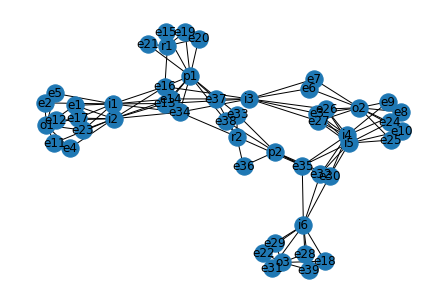

In [13]:
pg.basic_graphviz(log_graph)

In [5]:
week_logs = n4j.split_by_days_of_week(log, set(range(5)))

In [6]:
graphs = n4j.get_weekly_graphs(log, set(range(5)))

graph from week [2020-07-06, 2020-07-13):


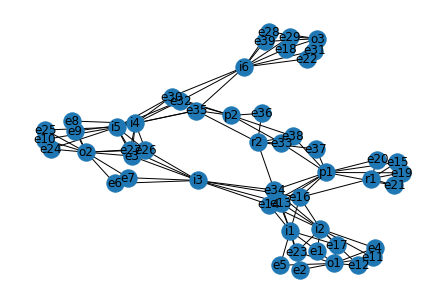

In [7]:
from collections import Counter
for k, v in graphs.items():
    print(f'graph from week [{k}, {k + timedelta(days=7)}):')
    pg.show_graph_plt(v)

In [8]:
def e_to_e_with_obj_within(log):
    # setup
    events = log['ocel:events']
    objects = log['ocel:objects']
    graph = nx.DiGraph()

    # add all nodes
    graph.add_nodes_from([(k, v) for k, v in events.items()])
    graph.add_nodes_from([(k, v) for k, v in objects.items()])
    
    # add all edges
    for e, v in events.items():
        # get all event df
        # e_df = {o: graph.nodes['object_events'][-1] for o in v['ocel:omap'] if 'object_events' in graph.nodes[o]}

        for o in v['ocel:omap']:
            if not list(graph.predecessors(o)):
                graph.nodes[o]['object_events'] = []
                graph.add_edge(e, o)
                #for df in e_df.values():
                #    graph.add_edge(e, o)
            elif not list(graph.successors(o)):
                graph.add_edge(o, e)
            else:
                graph.add_edge(graph.nodes[o]['object_events'][-1], e)
                
            graph.nodes[o]['object_events'].append(e)
                

        graph.nodes[e].pop('ocel:omap')

    return graph

g = e_to_e_with_obj_within(log)
pg.save_graph_graphviz(g)

In [11]:
def e_to_e_with_obj_outside(log):
    # setup
    events = log['ocel:events']
    objects = log['ocel:objects']
    graph = nx.DiGraph()

    # add all nodes
    graph.add_nodes_from([(k, v) for k, v in events.items()])
    graph.add_nodes_from([(k, v) for k, v in objects.items()])
    
    # add all edges
    for e, v in events.items():
        # get all event df
        # e_df = {o: graph.nodes['object_events'][-1] for o in v['ocel:omap'] if 'object_events' in graph.nodes[o]}
        for o in v['ocel:omap']:
            if not list(graph.successors(o)):
                graph.nodes[o]['object_events'] = []
                graph.add_edge(o, e, df={o})
                #for df in e_df.values():
                #    graph.add_edge(e, o)
            else:
                src_e = graph.nodes[o]['object_events'][-1]
                if graph.has_edge(src_e, e):
                    graph[src_e][e]['objs'].add(o)
                else:
                    graph.add_edge(graph.nodes[o]['object_events'][-1], e, objs={o})
                
            graph.nodes[o]['object_events'].append(e)
                
        graph.nodes[e].pop('ocel:omap')

    return graph

g = e_to_e_with_obj_outside(log)
pg.save_graph_graphviz(g)

In [111]:
import ocel_features.util.data_organization as do
import itertools

In [123]:
test_log = ocel.import_log('../logs/running-example.jsonocel')

def get_time_binning(log):
    vol_series = [v['ocel:timestamp'] for v in log['ocel:events'].values()]
    return do.equal_time_width_bins(vol_series)


def get_date_range_binning(log, days):
    bins = n4j.split_by_days_of_week(log, days)
    date_bins = []
    for i, b in enumerate(bins):
        date_bins.extend([i for _ in range(len(bins[b]['ocel:events']))])
                          
    return date_bins


def remove_bin_gaps(bin_list):
    id_dict = {b: i for i, b in enumerate(set(bin_list))}
    return [id_dict[b] for b in bin_list]


def get_activity_binning(log, bin_list):
    curr_id = bin_list[0]
    bin_volatility = [0 for i in range(bin_list[-1]+1)]
    head = 0
    tail = 0
    
    for i, b in enumerate(bin_list):
        if b != curr_id:
            series = bin_list[head:tail]
            bin_volatility[curr_id] = len(series)
            curr_id = b
            head = tail
            
        tail = tail + 1
            
    return bin_volatility

def bins_func(log, bin_list, func):
    curr_id = bin_list[0]
    bin_volatility = [0 for i in range(bin_list[-1]+1)]
    head = 0
    tail = 0
    
    for i, b in enumerate(bin_list):
        if b != curr_id:
            # get series of events
            series = dict(itertools.islice(log['ocel:events'].items(), head, tail))
            bin_volatility[curr_id] = func(series, log)
            curr_id = b
            head = tail
            
        tail = tail + 1
            
    return bin_volatility

def activity_count(series, log):
    return len(series)

def total_obj_count(series, log):
    return sum([len(series[e]['ocel:omap']) for e in series])

def total_unique_obj_count(series, log):
    return len({len(series[e]['ocel:omap']) for e in series})

        
db = get_date_range_binning(test_log, [0])

# print(get_time_binning(test_log))
# binning = get_time_binning(test_log)
binning = get_date_range_binning(test_log, range(5))

ab_separate = bins_func(test_log, binning, total_obj_count)
ab = bins_func(test_log, remove_bin_gaps(binning), total_unique_obj_count)

[1550, 3068, 3535, 2910, 3670, 3938, 3176, 3323, 3713, 3936, 3232, 3188, 3769, 3509, 3513, 4631, 3865, 3786, 3904, 3389, 3795, 3409, 3474, 3556, 3617, 3740, 3699, 4302, 3846, 3522, 3612, 3333, 3373, 3961, 4048, 3770, 3941, 3659, 4251, 3599, 3564, 3896, 3745, 3680, 3399, 2556, 1704, 1607, 1349, 1389, 3161, 3329, 1475, 361, 332, 106, 68, 38, 42, 53, 14, 32, 26, 31, 14, 16, 0]
[12, 21, 20, 24, 24, 24, 23, 22, 24, 23, 23, 21, 24, 22, 24, 27, 23, 25, 23, 22, 25, 25, 19, 23, 25, 22, 22, 25, 22, 24, 26, 19, 24, 24, 23, 23, 25, 24, 26, 22, 23, 26, 24, 24, 21, 20, 17, 19, 17, 15, 23, 24, 17, 11, 9, 6, 3, 3, 4, 3, 2, 2, 2, 2, 2, 1, 0]


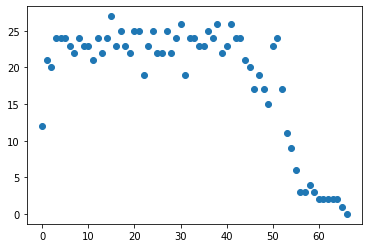

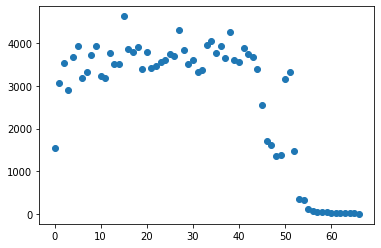

In [119]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.scatter(list(range(len(ab))), ab)
plt.show()

fig, ax = plt.subplots()
ax.scatter(list(range(len(ab_separate))), ab_separate)
plt.show()

In [124]:
def series_differences_absolute(series):
    out = [0]*(len(series)-1)
    for i in (range(len(series) - 1)):
        out[i] =  series[i+1] - series[i]
        
    return out

def series_differences_percentage(series, norm=False):
    out = [0]*(len(series)-1)
    for i in (range(len(series) - 1)):
        if series[i] != 0:
            out[i] =  (series[i+1] - series[i]) / series[i]
        else:
            out[i] = 1
            
    if norm:
        max_val = max(out)
        return list(map(lambda x: x/max_val, out))
        
    return out

d1 = series_differences_percentage(ab)
d2 = series_differences_percentage(ab_separate)
        

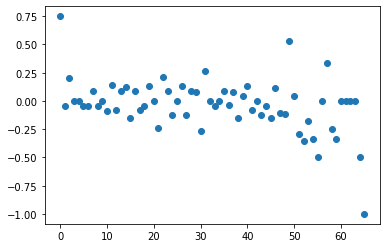

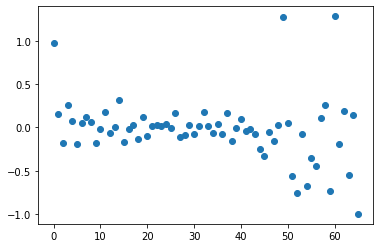

In [125]:
fig, ax = plt.subplots()
ax.scatter(list(range(len(d1))), d1)
plt.show()

fig, ax = plt.subplots()
ax.scatter(list(range(len(d2))), d2)
plt.show()